# ECE 529/629 - Project 4

# Name: Cameron Cebula
## Concrete Crack Dataset

This dataset is from https://www.kaggle.com/arunrk7/surface-crack-detection

**Please download the dataset from Kaggle to the datasets/concrete_crack/ folder before running this notebook.**

In [57]:
import os
import cv2
import csv
import numpy as np
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import pathlib
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical

import pandas as pd

The following variable will store information about models and their performance. This information will be printed in Part 4 of the project. **ONLY RUN THIS CELL WHEN YOU FIRST START THIS NOTEBOOK** or when you want to clear the information about all the models.

In [70]:
model_performance = []

The following functions record and print model information. The use of `record_model_performance` is shown in Part 0-1. The use of `print_model_performance` is shown in Part 4.

In [95]:
def record_model_performance(name, description, input_size, parameter_count, accuracy):
    global model_performance
    model_performance = model_performance + [[name, description, input_size, parameter_count, accuracy]]

def plot_model_performance():
    name = []
    params = []
    accuracy = []
    for i in range(len(model_performance)):
        name = name + [str(model_performance[i][0])+" "+str(model_performance[i][2])]
        params = params + [model_performance[i][3]]
        accuracy = accuracy + [model_performance[i][4]]
    fig, ax = plt.subplots(figsize=(15,10))
    plt.ylim(0.9,1.01)
    ax.scatter(params, accuracy)
    ax.set_xlabel('number of parameters')
    ax.set_ylabel('accuracy')
    for i, txt in enumerate(name):
        ax.annotate(txt, (params[i], accuracy[i]+np.random.randint(1,10)/4000.-0.00125))

    
def print_model_performance():
    print('{0:10s} {1:20s} {2:>12s} {3:>16s} {4:>9s}'.format("name", "description", "input size", 
                                                              "parameter count", "accuracy"))
    for i in range(len(model_performance)):
          print('{0:10s} {1:20s} {2:>12d} {3:>16d} {4:>9.5f}'.format(model_performance[i][0], 
                                                                      model_performance[i][1], 
                                                                      model_performance[i][2], 
                                                                      model_performance[i][3], 
                                                                      model_performance[i][4]))
    
    plot_model_performance()

The following parameters can be used as a global setting for the size of the input image (up to 227). Feel free to use this paramter when constructing your CNN below so you don't have to change the code every time you change with input image size. Note that large values require more memory and smaller values reduce the quality of the input images.

As noted in Part 4, **you are required to run your models with at least two different values for the size parameter**. When you do the second run, you can simply change this parameter here and rerun your notebook. Start with the largest value of `size` that you want to try to see if the notebook crashes because it runs out of memory. (If you increase the value later and crash, then the earlier results are lost. If you decrease the `size` value, you do not need more memory than previously.) If you don't reset the `model_performance` variable above, then results from both runs will be retained.

In [109]:
size = 64

## Part 0-1: Loading of Dataset

The following code loads the data and shows the construction of a simple ANN (not CNN).

In [110]:
base_path='datasets/concrete_crack/'

def load_images(path, size):
    images = os.listdir(path)
    images_array = np.array(images)
    imageslist = []
    for i in range(len(images_array)):
        im = img_to_array(load_img(path+images_array[i],target_size=(size,size))) / 255.
        imageslist.append(im)
    return imageslist    

crack_images = load_images(base_path + 'Positive/', size)
non_crack_images = load_images(base_path + 'Negative/', size)
images = np.array(crack_images + non_crack_images)

#labels = np.full(len(crack_images), (1,0))
#labels =np.append(labels, np.full(len(non_crack_images), (0,1)))
crack_labels = np.tile((1, 0),(len(crack_images),1))
non_crack_labels = np.tile((0, 1),(len(non_crack_images),1))
labels = np.append(crack_labels, non_crack_labels, axis=0)

In [111]:
images.shape

(40000, 64, 64, 3)

In [112]:
labels.shape

(40000, 2)

In [113]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

In [114]:
X_train.shape

(32000, 64, 64, 3)

In [115]:
y_train.shape

(32000, 2)

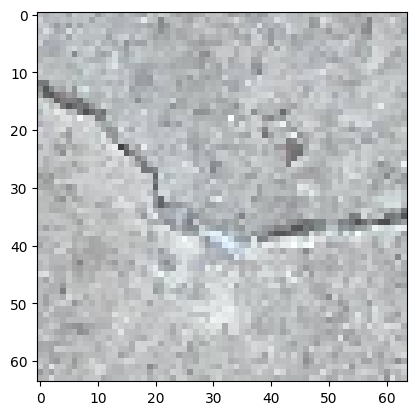

In [116]:
plt.imshow(cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB))
plt.show()

In [117]:
y_train[0]

array([1, 0])

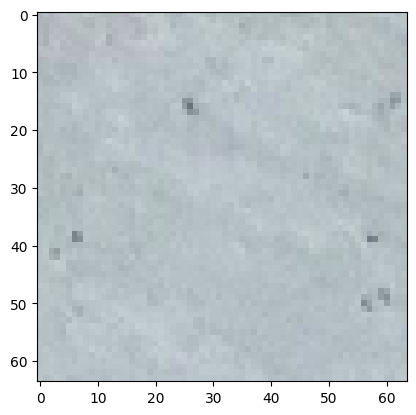

In [118]:
plt.imshow(cv2.cvtColor(X_train[4], cv2.COLOR_BGR2RGB))
plt.show()

In [119]:
y_train[4]

array([0, 1])

## Part 0-2: Example ANN

The following code constructs and trains the neural networks. You may use any number of epochs of training. Make sure to train long enough to reach close to "steady state." In my experiments, 10-20 epochs have worked well. 

In [120]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(size, size, 3)),
    keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=2, activation='sigmoid'),
])

model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=16)
score, acc = model.evaluate(X_test, y_test)

Epoch 1/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.4948 - loss: 0.7402 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 2/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.4957 - loss: 0.6934 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 3/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.4874 - loss: 0.6934 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 4/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.4982 - loss: 0.6930 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 5/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.4886 - loss: 0.6934 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 6/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.4890 - loss: 0.6933 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 7/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.4910 - loss: 0.6933 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 8/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.4901 - loss: 0

The following code prints the accuracy of the model and the number of parameters in the model.

In [121]:
record_model_performance(name="default size=64", 
                         description="ANN from Part 0-2", 
                         input_size=size, 
                         parameter_count=model.count_params(), 
                         accuracy=acc)

The following code dislays up to 10 images that were classified incorrectly. ([1 0] indicates that the image is labeled having a crack, but was classified as not having a crack. [0 1] indicates the opposite.)

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
3986 errors:
[0 1]


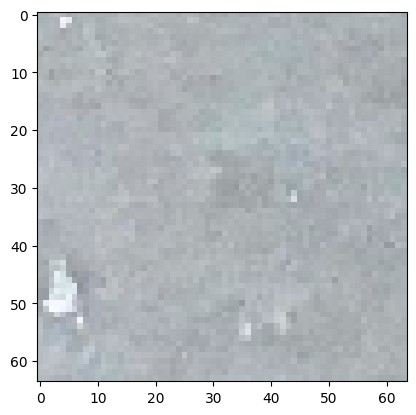

[0 1]


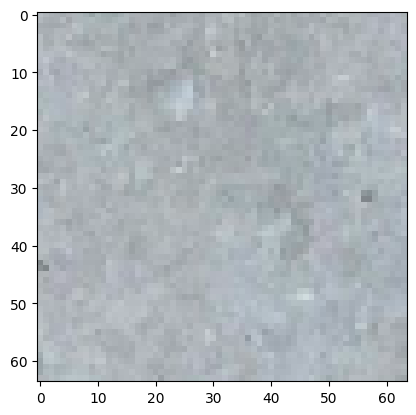

[0 1]


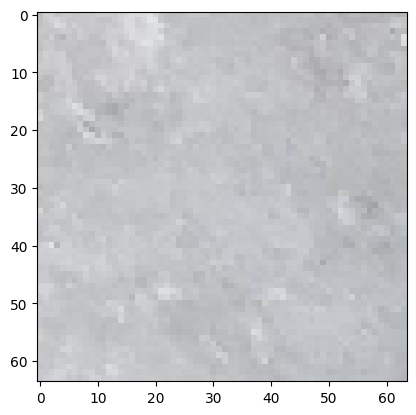

[0 1]


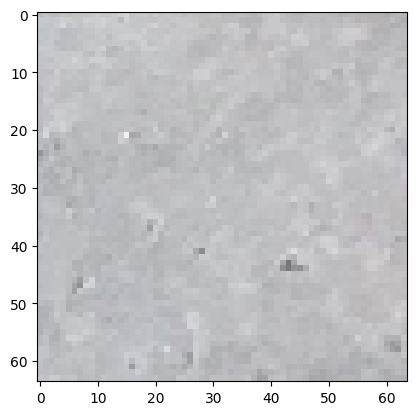

[0 1]


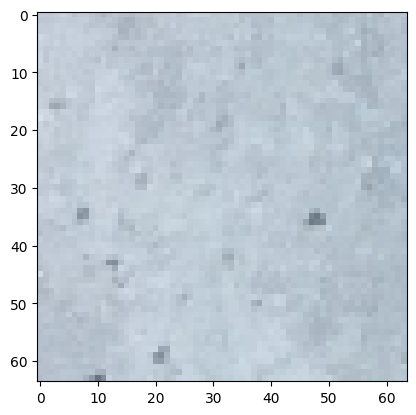

[0 1]


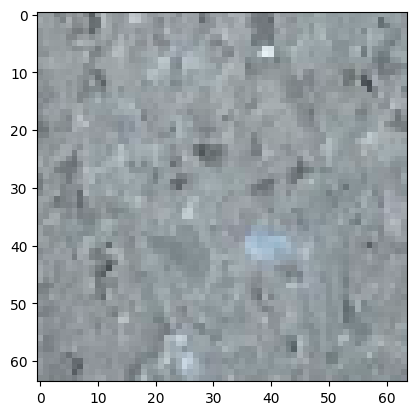

[0 1]


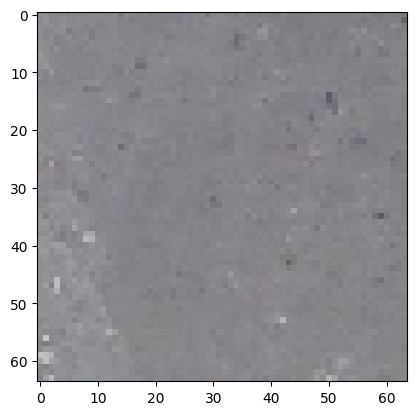

[0 1]


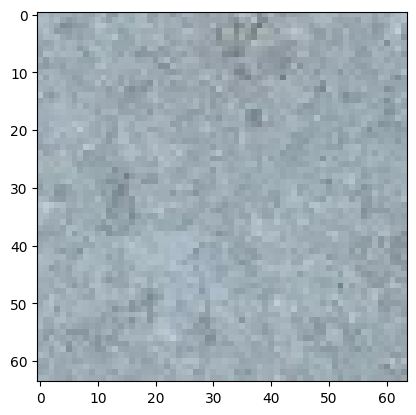

[0 1]


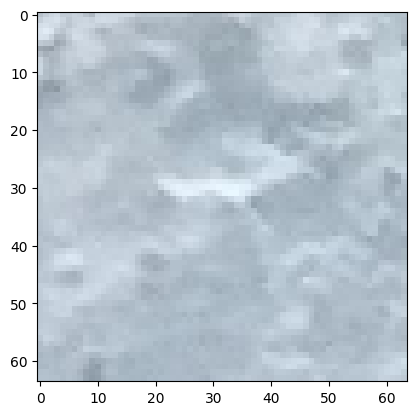

[0 1]


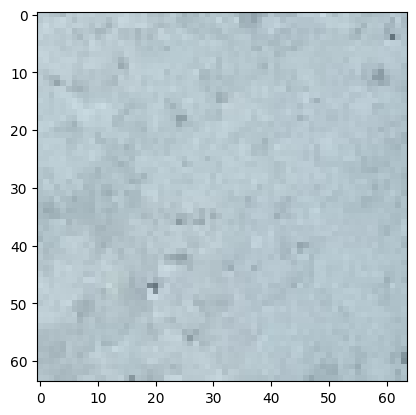

In [122]:
y_pred = model.predict(X_test)
misclassified_samples = X_test[(y_test != np.rint(y_pred).astype(int))[:,0]]
misclassified_labels = y_test[(y_test != np.rint(y_pred).astype(int))[:,0]]

print(str(len(misclassified_samples)) + " errors:")

for i in range(min(len(misclassified_samples),10)):
    print(misclassified_labels[i])
    plt.imshow(cv2.cvtColor(misclassified_samples[i], cv2.COLOR_BGR2RGB))
    plt.show()

## Part 1: Custom CNN
Construct and train a CNN from scratch (i.e., without using transfer learning).

In [123]:
model_custom = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='SAME',
                  input_shape=(size,size,3)),
    keras.layers.Conv2D(30, (3, 3), activation='relu', padding='SAME'),
    keras.layers.Conv2D(30, (3, 3), activation='relu', padding='SAME'),
    keras.layers.Conv2D(30, (3, 3), activation='relu', padding='SAME'),
    keras.layers.Conv2D(30, (3, 3), activation='relu', padding='SAME'),
    keras.layers.Conv2D(30, (3, 3), activation='relu', padding='SAME'),
    keras.layers.Conv2D(30, (3, 3), activation='relu', padding='SAME'),
    #keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='softmax')
])

model_custom.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model_custom.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=16)
score, acc = model_custom.evaluate(X_test, y_test)

Epoch 1/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 116s 64ms/step - accuracy: 0.6138 - loss: 0.6664 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 2/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 109s 60ms/step - accuracy: 0.5070 - loss: 0.7164 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 3/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 109s 61ms/step - accuracy: 0.4887 - loss: 0.6933 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 4/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 109s 60ms/step - accuracy: 0.4893 - loss: 0.6933 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 5/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 111s 62ms/step - accuracy: 0.4893 - loss: 0.6933 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 6/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 143s 79ms/step - accuracy: 0.4893 - loss: 0.6933 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 7/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 109s 60ms/step - accuracy: 0.4893 - loss: 0.6933 - val_accuracy: 0.5034 - val_loss: 0.6931
Epoch 8/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 105s 58ms/step - accuracy: 

In [124]:
record_model_performance(name="Custom CNN Size=64",               # recording custom CNN in model performance for Part 4.
                         description="Custom CNN from Part 1", 
                         input_size=size, 
                         parameter_count=model_custom.count_params(), 
                         accuracy=acc)

## Part 2: CNN with Transfer Learning
Pick a pretrained image classification network from https://keras.io/api/applications/ and use it for transfer learning. Construct and train a CNN that is based on transfer learning.

### First CNN with Transfer Learning

In [125]:
transfer_model = keras.applications.MobileNet(   # instantiating the MobileNet transfer model
    weights='imagenet',
    input_shape=(size, size, 3),
    include_top=False
)

transfer_model.trainable = False    # False so we are not retraining the model

model_tl1 = keras.models.Sequential([         
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='SAME',
                  input_shape=(size,size,3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='SAME'),
    keras.layers.Conv2D(3, (3, 3), activation='relu', padding='SAME'),
    transfer_model,                  #  adding the transfer model to the CNN
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='softmax')
])

model_tl1.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model_tl1.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=16)
score, acc = model_tl1.evaluate(X_test, y_test)

C:\Users\camre\AppData\Local\Temp\ipykernel_5640\3631540597.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  transfer_model = keras.applications.MobileNet(


Epoch 1/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 352s 195ms/step - accuracy: 0.9796 - loss: 0.0511 - val_accuracy: 0.9962 - val_loss: 0.0120
Epoch 2/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 320s 178ms/step - accuracy: 0.9960 - loss: 0.0147 - val_accuracy: 0.9981 - val_loss: 0.0068
Epoch 3/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 308s 171ms/step - accuracy: 0.9967 - loss: 0.0119 - val_accuracy: 0.9978 - val_loss: 0.0070
Epoch 4/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 302s 168ms/step - accuracy: 0.9971 - loss: 0.0108 - val_accuracy: 0.9972 - val_loss: 0.0092
Epoch 5/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 303s 168ms/step - accuracy: 0.9969 - loss: 0.0102 - val_accuracy: 0.9981 - val_loss: 0.0081
Epoch 6/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 302s 168ms/step - accuracy: 0.9967 - loss: 0.0115 - val_accuracy: 0.9981 - val_loss: 0.0056
Epoch 7/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 301s 167ms/step - accuracy: 0.9969 - loss: 0.0102 - val_accuracy: 0.9981 - val_loss: 0.0072
Epoch 8/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 300s 167ms/step - ac

In [126]:
# Recording Model CNN Transfer Learning 1's performance
record_model_performance(name="TL1 Size=64", 
                         description="CNN with Transfer Learning Part 2", 
                         input_size=size, 
                         parameter_count=model_tl1.count_params(), 
                         accuracy=acc)

### Second CNN with Transfer Learning

In [127]:
model_tl2 = keras.models.Sequential([ # A simpler CNN transfer learning model
    keras.layers.Conv2D(filters=3, kernel_size=3, strides=1, activation='relu', padding='SAME',
                  input_shape=(size,size,3)),
    transfer_model,
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='softmax')
])

model_tl2.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model_tl2.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=16)
score, acc = model_tl2.evaluate(X_test, y_test)

Epoch 1/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 253s 140ms/step - accuracy: 0.9800 - loss: 0.0501 - val_accuracy: 0.9969 - val_loss: 0.0106
Epoch 2/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 227s 126ms/step - accuracy: 0.9953 - loss: 0.0181 - val_accuracy: 0.9966 - val_loss: 0.0085
Epoch 3/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 227s 126ms/step - accuracy: 0.9964 - loss: 0.0122 - val_accuracy: 0.9978 - val_loss: 0.0081
Epoch 4/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 223s 124ms/step - accuracy: 0.9969 - loss: 0.0095 - val_accuracy: 0.9978 - val_loss: 0.0073
Epoch 5/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 228s 127ms/step - accuracy: 0.9961 - loss: 0.0125 - val_accuracy: 0.9975 - val_loss: 0.0074
Epoch 6/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 229s 127ms/step - accuracy: 0.9965 - loss: 0.0107 - val_accuracy: 0.9975 - val_loss: 0.0073
Epoch 7/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 230s 128ms/step - accuracy: 0.9967 - loss: 0.0089 - val_accuracy: 0.9978 - val_loss: 0.0080
Epoch 8/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 212s 118ms/step - ac

In [128]:
# Recording performance of transfer learning 2 
record_model_performance(name="TL2 Size=64", 
                         description="CNN with Transfer Learning Part 2", 
                         input_size=size, 
                         parameter_count=model_tl2.count_params(), 
                         accuracy=acc)

## Part 3: Minimal Model

In this part, find the smallest possible model (in terms of number parameters) that achieves at least 99.5% accuracy on the test set.

In [129]:
# Simple model trying to achieve 99.5% accuracy with the least number of parameters.
model_mm = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding='SAME',
                  input_shape=(size,size,3)),
    keras.layers.Conv2D(30, (3, 3), activation='relu', padding='SAME'),
    keras.layers.Conv2D(30, (3, 3), activation='relu', padding='SAME'),
    keras.layers.Conv2D(20, (3, 3), activation='relu', padding='SAME'),
    keras.layers.Conv2D(10, (3, 3), activation='relu', padding='SAME'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='softmax')
])

model_mm.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model_mm.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=16)
score, acc = model_mm.evaluate(X_test, y_test)

Epoch 1/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 55s 30ms/step - accuracy: 0.7156 - loss: 0.5588 - val_accuracy: 0.9741 - val_loss: 0.1075
Epoch 2/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 52s 29ms/step - accuracy: 0.9700 - loss: 0.1059 - val_accuracy: 0.9912 - val_loss: 0.0318
Epoch 3/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 52s 29ms/step - accuracy: 0.9869 - loss: 0.0442 - val_accuracy: 0.9934 - val_loss: 0.0261
Epoch 4/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 52s 29ms/step - accuracy: 0.9895 - loss: 0.0350 - val_accuracy: 0.9934 - val_loss: 0.0242
Epoch 5/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 52s 29ms/step - accuracy: 0.9905 - loss: 0.0308 - val_accuracy: 0.9937 - val_loss: 0.0234
Epoch 6/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 53s 29ms/step - accuracy: 0.9916 - loss: 0.0274 - val_accuracy: 0.9931 - val_loss: 0.0234
Epoch 7/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 53s 29ms/step - accuracy: 0.9922 - loss: 0.0247 - val_accuracy: 0.9934 - val_loss: 0.0233
Epoch 8/20
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 53s 29ms/step - accuracy: 0.9931 -

In [130]:
# Reecording the Minimal Models performace.
record_model_performance(name="Minimal Model Size=64", 
                         description="CNN Minimal Model from Part 3", 
                         input_size=size, 
                         parameter_count=model_mm.count_params(), 
                         accuracy=acc)

## Part 4: Summary

Please summarize the results from your experiments in the following table. In the end, your table should have **at least eight entries** (one ANN, on custom CNN, two CNNs with transfer learning) * 2 `size` values. You are welcome to try out and report the results of more `size` values and more CNN architecture.

name       description            input size  parameter count  accuracy
Custom CNN Custom CNN from Part 1           32           111658   0.99450
TL1        CNN with Transfer Learning Part 2           32          3241925   0.99462
TL2        CNN with Transfer Learning Part 2           32          3230998   0.98200
Minimal Model CNN Minimal Model from Part 3           32            30048   0.99475
default    ANN from Part 0-2              32            30048   0.99475
default size=64 ANN from Part 0-2              64          1589762   0.50175
Custom CNN Size=64 Custom CNN from Part 1           64           295978   0.50175
TL1 Size=64 CNN with Transfer Learning Part 2           64          3248069   0.99437
TL2 Size=64 CNN with Transfer Learning Part 2           64          3237142   0.99775
Minimal Model Size=64 CNN Minimal Model from Part 3           64            45408   0.99050


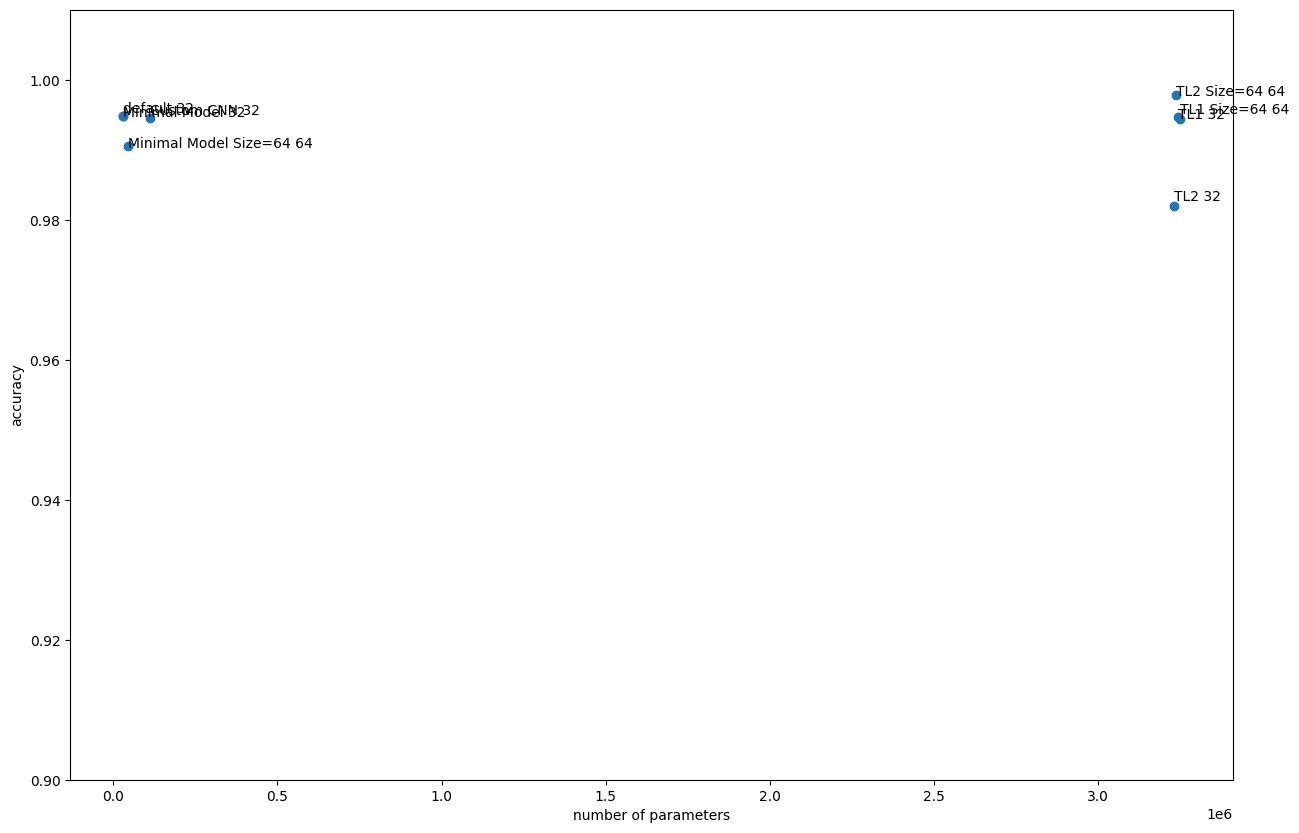

In [131]:
print_model_performance()

If you have not yet done so, please rerun your notebook with a different `size` parameter now. You should see both results in the table when you get back to the cell above.

Which model has the highest accuracy?

Answer: The 2nd transfer learning model with a size of 64 was the most accurate model. 

Which model has the fewest parameters (and an accuracy of at least 99.5%)?

Answer: Minimal Model

Which model would you choose? Why?

Answer: I would choose the minimal model as it has very high accuracy, almost the same or better than the other models, and is lighter than all the other models. By lighter I mean it is faster to train, has less parameters, takes less memory and other resources. 
If accuracy is all that mattered, the transfer learning part 2 model would be the best choice. 

Discuss what else you observe in your results and what you have learned.

Answer: Transfer learning models took the most amount of time having each epoch last over 40 seconds. On a more complex photo recognition problem these transfer learning models would be very useful. When it comes to simple problems transfer learning seems to be overkill, unless you choose a light transfer learning model. When it comes to simple problems building your own model specifically for the task at hand seems to be the best option. Also CNN's are much more accuracte than ANN's when it comes photo recognition, light CNN models quickly beat out ANN's accuracy scores.

The size variable also had a huge effect on training time, making training each epoch over 200 seconds with a size of 64. The increase in size also does not seem to have much increase, as it was very dependent on the model, some models had great effect like the second transfer learning model, but other models decreased.